In [67]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

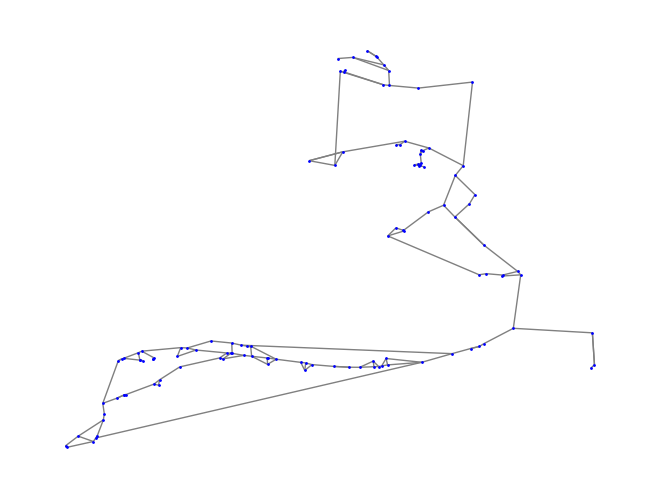

In [101]:
def snap_to_nearest_point(line, points, tolerance=0.001):
    """
    Snaps the start and end points of a line to the nearest points (confluences)
    if they are within a specified tolerance distance.
    """
    start_point = Point(line.coords[0])
    end_point = Point(line.coords[-1])
    
    # Snap the start point
    nearest_start = points.geometry.distance(start_point).idxmin()
    if start_point.distance(points.geometry.iloc[nearest_start]) > tolerance:
        # Don't snap if it's beyond tolerance
        snapped_start = start_point
    else:
        snapped_start = points.geometry.iloc[nearest_start]

    # Snap the end point
    nearest_end = points.geometry.distance(end_point).idxmin()
    if end_point.distance(points.geometry.iloc[nearest_end]) > tolerance:
        # Don't snap if it's beyond tolerance
        snapped_end = end_point
    else:
        snapped_end = points.geometry.iloc[nearest_end]
    
    return snapped_start, snapped_end

# Load points (confluences) and lines (connections) shapefiles
points = gpd.read_file('D:/River connectivity/shp for river network/Sep 2024 flood/nodes-18-9-2024.shp')
lines = gpd.read_file('D:/River connectivity/shp for river network/Sep 2024 flood/cleaned input for py/edges-18-9-2024.shp')

# Ensure both shapefiles use the same CRS (coordinate reference system)
if points.crs != lines.crs:
    lines = lines.to_crs(points.crs)

# Validate geometries
if not points.is_valid.all() or not lines.is_valid.all():
    raise ValueError("Invalid geometries found in shapefiles.")

# Create an empty graph
G = nx.MultiGraph()
# G = nx.Graph()

# Add nodes to the graph (using the points)
for idx, row in points.iterrows():
    G.add_node(idx, pos=(row.geometry.x, row.geometry.y))

# Add edges to the graph (using the lines)
for idx, row in lines.iterrows():
    # Snap line endpoints to nearest points
    snapped_start, snapped_end = snap_to_nearest_point(row.geometry, points)
    
    # Find the nearest nodes
    start_node = points.geometry.distance(snapped_start).idxmin()
    end_node = points.geometry.distance(snapped_end).idxmin()
    
    # Add the edge between the two closest nodes
    if start_node != end_node:  # Avoid self-loops
        G.add_edge(start_node, end_node)

# Plot the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=1, node_color='blue', edge_color='gray')
plt.show()



In [103]:
# Calculate graph-theoretic connectivity (alpha)
alpha = nx.edge_connectivity (G)
avg_shortest_path = nx.average_shortest_path_length(G)
diameter = nx.diameter(G)
fiedler_value = nx.algebraic_connectivity(G)
assortativity = nx.degree_assortativity_coefficient(G)
density = nx.density(G)

print(f"Graph-theoretic connectivity (α): {alpha}")
print(f"avg_shortest_path: {avg_shortest_path}")
print(f"diameter: {diameter}")
print(f"fiedler_value: {fiedler_value}")
print(f"assortativity: {assortativity}")
print(f"density: {density}")

Graph-theoretic connectivity (α): 1
avg_shortest_path: 12.177603940315805
diameter: 28
fiedler_value: 0.004179873221785971
assortativity: 0.11413043478260336
density: 0.023612921918006662
